# Weibull Accelerated Failure Time Model

This sub-repository contains the Python notebooks for the tutorial "Survival of the Fittest: Classical and Machine Learning Methods for Time-to-Event Modeling" of D. Meier and A. Sturge for the Data Science Working Group of the Swiss Actuarial Association, see https://actuarialdatascience.org.

Before running this notebook make sure that you have created all datasets by running the two notebooks "IPUMS NHIS Dataset" and "Synthetic Dataset".

In [1]:
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import WeibullAFTFitter
from sklearn.model_selection import train_test_split
from sksurv.metrics import integrated_brier_score
from sksurv.util import Surv
from sklearn.metrics import log_loss
from scipy.special import logit
import time
import sys
import importlib

modules = [
    'polars',
    'pandas',
    'seaborn',
    'matplotlib',
    'numpy',
    'lifelines',
    'sksurv',
    'sklearn',
    'scipy'
]

print(f"Python version: {sys.version}\n")

for module in modules:
    try:
        mod = importlib.import_module(module)
        version = getattr(mod, '__version__', 'built-in or no __version__')
        print(f"{module} version: {version}")
    except ImportError:
        print(f"{module} is not installed.")

sns.set()

Python version: 3.9.21 (main, Dec 11 2024, 10:23:52) 
[Clang 14.0.6 ]

polars version: 1.29.0
pandas version: 1.5.3
seaborn version: 0.13.2
matplotlib version: 3.9.2
numpy version: 1.26.4
lifelines version: 0.26.4
sksurv version: 0.21.0
sklearn version: 1.2.2
scipy version: 1.13.1


In [8]:
df = pl.read_csv("data/prepared_data.csv")
df = df.with_columns(pl.col("earnings_quantile").cast(pl.Float64))
df = df.with_columns(pl.col("HRSLEEP").cast(pl.Int64))
df

AGE,YEAR,BMICALC,SMOKESTATUS2,USBORN,HIPRIVATEE,HRSLEEP,FAMKIDNO,MARSTAT,EDUC,earnings_quantile,time,event,REGION_2,REGION_3,REGION_4,MALE
i64,i64,f64,bool,bool,bool,i64,i64,bool,bool,f64,i64,bool,i64,i64,i64,bool
28,2000,null,false,true,true,null,4,true,false,null,20,false,0,0,0,true
35,2000,29.0,false,true,true,null,4,true,false,null,20,false,0,0,0,false
34,2000,null,false,true,true,null,4,false,false,null,20,false,0,0,0,false
38,2000,null,false,true,true,null,3,true,false,null,20,false,1,0,0,false
46,2000,null,false,true,true,null,3,true,false,null,20,false,1,0,0,true
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
56,2016,24.0,false,true,true,8,0,false,false,0.931819,20,false,0,0,1,true
58,2016,31.4,false,true,true,6,0,false,true,0.378244,20,false,0,1,0,true
71,2016,25.0,false,false,false,5,0,true,false,0.378274,20,false,0,0,0,false


Fitting time: 16.01 seconds


<lifelines.WeibullAFTFitter: fitted with 185373 total observations, 170161 right-censored observations>
             duration col = 'time'
                event col = 'event'
   number of observations = 185373
number of events observed = 15212
           log-likelihood = -77571.65
         time fit was run = 2025-08-24 20:21:17 UTC

---
                           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                          
lambda_ Intercept         10.32  30357.60      0.35            9.64           11.00            15411.84            59797.13
        AGE               -0.14      0.87      0.00           -0.14           -0.13                0.87                0.88
        BMICALC            0.35      1.42      0.02            0.31            0.39                1.37                1.48
        I(BMICALC ** 2)   -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
        SMOKESTATUS2      -1.11      0.33      0.04           -1.19           -1.03                0.31                0.36
        USBORN            -0.71      0.49      0.05           -0.81           -0.61                0.44                0.54
        HIPRIVATEE         0.22      1.25      0.03            0.16            0.29                1.18                1.33
        HRSLEEP            0.10      1.10      0.03            0.04            0.16                1.04                1.17
        I(HRSLEEP ** 2)   -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
        FAMKIDNO          -0.02      0.98      0.03           -0.08            0.04                0.93                1.04
        MARSTAT            0.59      1.80      0.03            0.52            0.65                1.69                1.91
        EDUC               0.39      1.47      0.04            0.31            0.46                1.36                1.59
        earnings_quantile  2.36     10.58      0.08            2.21            2.51                9.13               12.26
        REGION_2          -0.08      0.92      0.05           -0.18            0.01                0.84                1.01
        REGION_3          -0.13      0.88      0.04           -0.21           -0.04                0.81                0.96
        REGION_4           0.05      1.05      0.05           -0.04            0.14                0.96                1.15
        MALE              -0.91      0.40      0.03           -0.98           -0.85                0.38                0.43
rho_    Intercept         -0.59      0.56      0.01           -0.60           -0.57                0.55                0.57

                           cmp to      z      p  -log2(p)
param   covariate                                        
lambda_ Intercept            0.00  29.84 <0.005    647.50
        AGE                  0.00 -80.20 <0.005       inf
        BMICALC              0.00  17.81 <0.005    233.36
        I(BMICALC ** 2)      0.00 -17.98 <0.005    237.61
        SMOKESTATUS2         0.00 -27.51 <0.005    550.96
        USBORN               0.00 -13.90 <0.005    143.52
        HIPRIVATEE           0.00   7.25 <0.005     41.16
        HRSLEEP              0.00   3.19 <0.005      9.45
        I(HRSLEEP ** 2)      0.00  -6.15 <0.005     30.25
        FAMKIDNO             0.00  -0.69   0.49      1.03
        MARSTAT              0.00  18.03 <0.005    239.05
        EDUC                 0.00  10.01 <0.005     75.89
        earnings_quantile    0.00  31.36 <0.005    714.61
        REGION_2             0.00  -1.77   0.08      3.71
        REGION_3             0.00  -2.96 <0.005      8.36
        REGION_4             0.00   1.08   0.28      1.84
        MALE                 0.00 -29.17 <0.005    618.88
rho_    Intercept            0.00 -76.09 <0.005       inf
---
Concordance = 0.

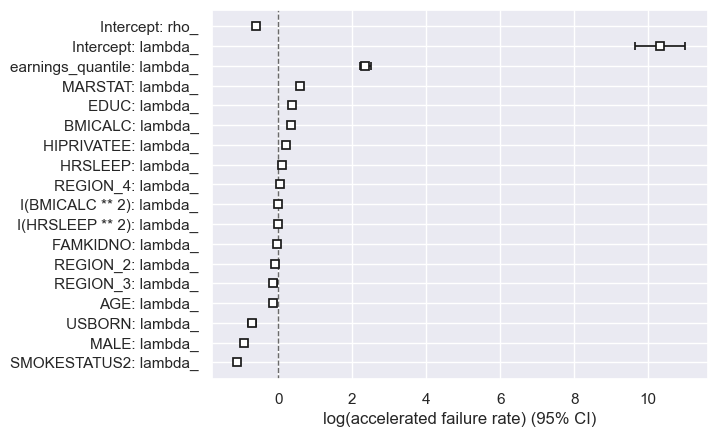

In [9]:
dfp = df.to_pandas()
dfp_nn = dfp.dropna()
dfp_nn = dfp_nn.replace({"time": {0: 0.01}}) # Model cannot handle time 0
formula = (
    "AGE + "
    "BMICALC + I(BMICALC ** 2) + "
    "SMOKESTATUS2 + "
    "USBORN + "
    "HIPRIVATEE + "
    "HRSLEEP + I(HRSLEEP ** 2) + "
    "FAMKIDNO + "
    "MARSTAT + "
    "EDUC + "
    "earnings_quantile + "
    "REGION_2 + REGION_3 + REGION_4 + "
    "MALE"
)

dfp_nn_train, dfp_nn_test = train_test_split(dfp_nn, test_size=0.2, random_state=0)

start_time = time.time()
weibull_aft = WeibullAFTFitter()
weibull_aft.fit(dfp_nn_train, duration_col="time", event_col="event", formula=formula)
print(f"Fitting time: {time.time() - start_time:.2f} seconds")

weibull_aft.print_summary()
weibull_aft.plot();

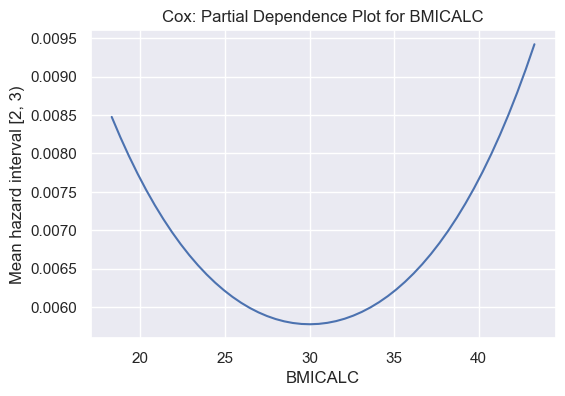

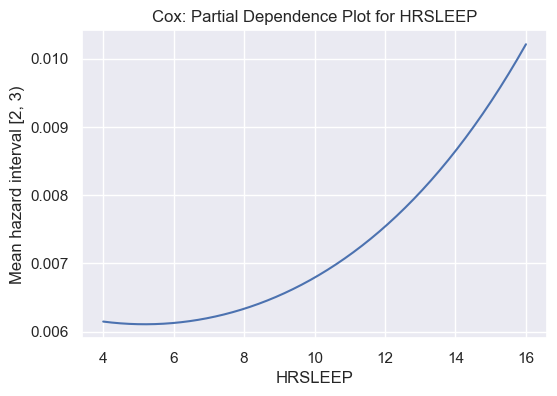

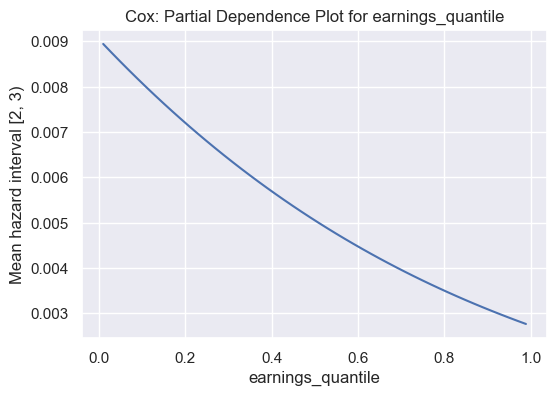

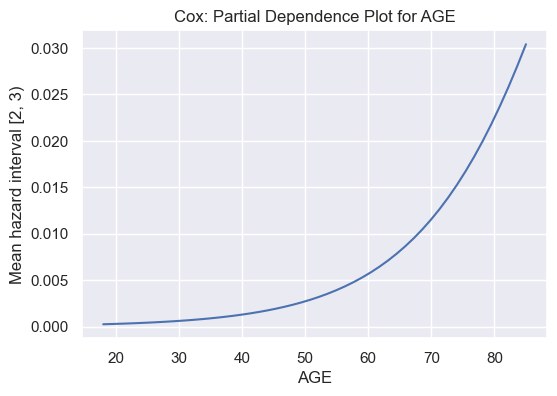

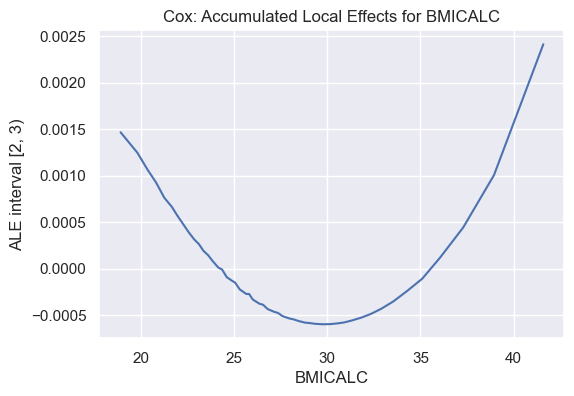

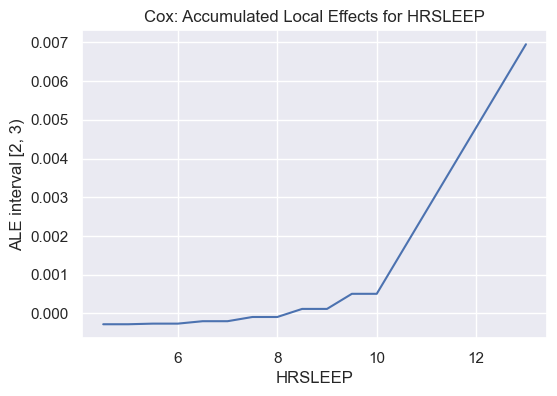

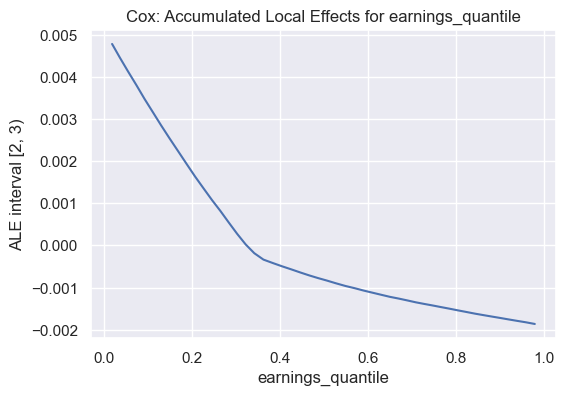

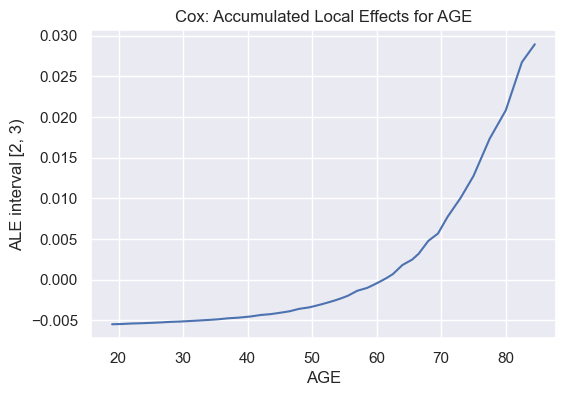

In [10]:
def plot_pdp(model, df, variable, t1, t2):
    x_vals = np.linspace(df[variable].quantile(0.01), df[variable].quantile(0.99), 50)
    y_vals = []
    for val in x_vals:
        df_copy = df.copy()
        df_copy[variable] = val
        pred_surv = model.predict_survival_function(df_copy).T.values
        y_vals.append((pred_surv[:,t1] - pred_surv[:,t2]).mean())
    plt.figure(figsize=(6, 4))
    plt.plot(x_vals, y_vals)
    plt.xlabel(variable)
    plt.ylabel(f"Mean hazard interval [{t1}, {t2})")
    plt.title(f"Cox: Partial Dependence Plot for {variable}")
    plt.show()

def plot_ale(model, df, variable, t1, t2):
    df_sorted = df.sort_values(by=variable)
    quantiles = np.linspace(0.01, 0.99, 51)
    bin_edges = df[variable].quantile(quantiles).values
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    ale_values = []
    for i in range(len(bin_edges) - 1):
        lower, upper = bin_edges[i], bin_edges[i+1]
        mask = (df[variable] >= lower) & (df[variable] < upper)
        df_bin = df[mask]
        
        if df_bin.empty:
            ale_values.append(0.0)
            continue
        
        df_low = df_bin.copy()
        df_high = df_bin.copy()
        df_low[variable] = lower
        df_high[variable] = upper

        pred_surv_high = model.predict_survival_function(df_high).T.values
        pred_surv_low = model.predict_survival_function(df_low).T.values
        pred_diff = (pred_surv_high[:,t1] - pred_surv_high[:,t2]) - (pred_surv_low[:,t1] - pred_surv_low[:,t2])
        ale_values.append(np.mean(pred_diff))
    
    # Accumulate local effects
    ale_accumulated = np.cumsum(ale_values)
    ale_centered = ale_accumulated - np.mean(ale_accumulated)  # Centering
    
    plt.figure(figsize=(6, 4))
    plt.plot(bin_centers, ale_centered)
    plt.xlabel(variable)
    plt.ylabel(f"ALE interval [{t1}, {t2})")
    plt.title(f"Cox: Accumulated Local Effects for {variable}")
    plt.show()

for var in ["BMICALC", "HRSLEEP", "earnings_quantile", "AGE"]:
    plot_pdp(weibull_aft, dfp_nn_test, var, 2, 3)

for var in ["BMICALC", "HRSLEEP", "earnings_quantile", "AGE"]:
    plot_ale(weibull_aft, dfp_nn_test, var, 2, 3)

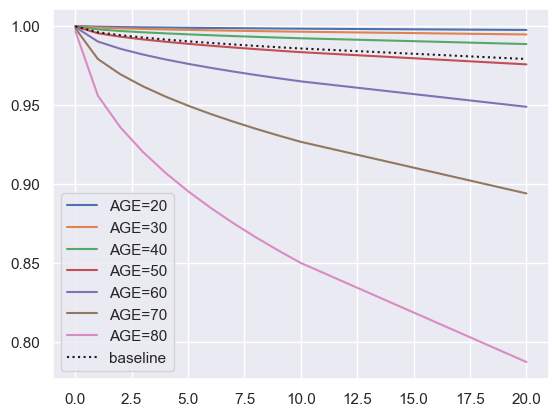

In [11]:
weibull_aft.plot_partial_effects_on_outcome(covariates='AGE', values=[20, 30, 40, 50, 60, 70, 80]);

In [24]:
c_index = weibull_aft.concordance_index_
print(f"C-index: {c_index:.4f}")

time_grid = np.arange(1,10)
pred_surv = weibull_aft.predict_survival_function(dfp_nn_test, times=time_grid)

y_test = Surv.from_dataframe("event", "time", dfp_nn_test)

ibs = integrated_brier_score(y_test, y_test, pred_surv.T.values, time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

in_interval = ((dfp_nn_test["event"] == 1) & (dfp_nn_test["time"] >= 2) & (dfp_nn_test["time"] < 3)).astype(int)
p_interval = pred_surv.T.values[:,1] - pred_surv.T.values[:,2]
logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [2, 3): {logloss:.4f}")

C-index: 0.8612
Integrated Brier Score: 0.0425
Log loss for interval [2, 3): 0.0517


/opt/anaconda3/lib/python3.9/site-packages/lifelines/utils/__init__.py:997: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  nonnumeric_cols = [col for (col, dtype) in df.dtypes.iteritems() if dtype.name == "category" or dtype.kind not in "biuf"]


Fitting time: 26.45 seconds


/opt/anaconda3/lib/python3.9/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.WeibullAFTFitter: fitted with 1.10112e+06 total observations, 985193 right-censored observations>
             duration col = 'T'
                event col = 'event'
   number of observations = 1.10112e+06
number of events observed = 115923
           log-likelihood = -447039.23
         time fit was run = 2025-08-28 11:57:27 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                             
lambda_ Intercept      20.83   1.12e+09       0.16            20.52            21.15             8.13e+08             1.53e+09
        AGE            -0.16       0.85       0.00            -0.17            -0.16                 0.85                 0.85
        BINARY         -2.18       0.11       0.01            -2.21            -2.16                 0.11                 0.12
        BMI             0.10       1.10       0.01             0.08             0.12                 1.08                 1.13
        GENDER          0.63       1.88       0.01             0.61             0.65                 1.84                 1.92
        I(BMI ** 2)    -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
        NUM1            0.02       1.02       0.02            -0.01             0.06                 0.99                 1.06
        NUM2           -0.00       1.00       0.02            -0.04             0.04                 0.96                 1.04
        NUM3           -3.06       0.05       0.02            -3.10            -3.02                 0.05                 0.05
        SBP            -0.02       0.98       0.00            -0.02            -0.01                 0.98                 0.99
        SD_SBP         -0.02       0.98       0.00            -0.02            -0.01                 0.98                 0.99
        TCL_HDL_RATIO  -0.32       0.73       0.00            -0.32            -0.31                 0.72                 0.74
rho_    Intercept      -0.57       0.57       0.00            -0.57            -0.56                 0.57                 0.57

                            z      p   -log2(p)
param   covariate                              
lambda_ Intercept      128.88 <0.005        inf
        AGE           -273.47 <0.005        inf
        BINARY        -168.89 <0.005        inf
        BMI              9.92 <0.005      74.70
        GENDER          60.11 <0.005        inf
        I(BMI ** 2)     -9.82 <0.005      73.18
        NUM1             1.19   0.23       2.09
        NUM2            -0.01   0.99       0.01
        NUM3          -148.67 <0.005        inf
        SBP            -28.84 <0.005     605.00
        SD_SBP          -8.51 <0.005      55.72
        TCL_HDL_RATIO  -77.14 <0.005        inf
rho_    Intercept     -207.15 <0.005        inf
---
Concordance = 0.89
AIC = 894104.46
log-likelihood ratio test = 302981.41 on 11 df
-log2(p) of ll-ratio test = inf

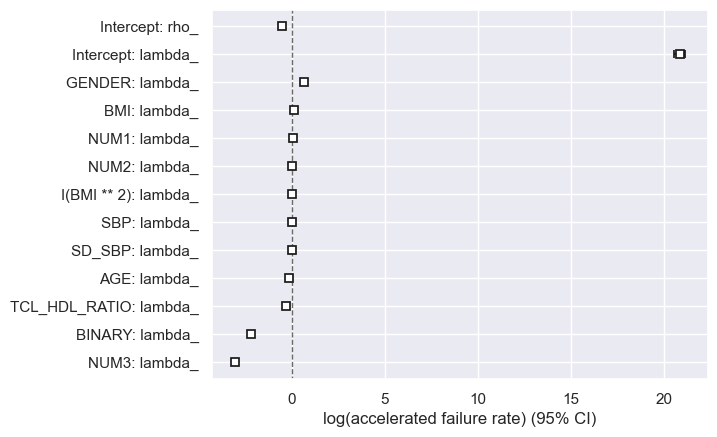

In [2]:
D2 = pd.read_csv("data/D2.csv")
D2["T"] = np.floor(D2["T"])
D2 = D2.replace({"T": {0: 0.01}}) # Model cannot handle time 0

formula_D2 = (
    "AGE + "
    "BMI + I(BMI ** 2) + "
    "SBP + "
    "TCL_HDL_RATIO + "
    "SD_SBP + "
    "NUM1 + "
    "NUM2 + "
    "NUM3 + "
    "BINARY + "
    "GENDER"
)

D2_train, D2_test = train_test_split(D2, test_size=0.2, random_state=0)

start_time = time.time()
weibull_aft_D2 = WeibullAFTFitter()
weibull_aft_D2.fit(D2_train, duration_col="T", event_col="event", formula=formula_D2)
print(f"Fitting time: {time.time() - start_time:.2f} seconds")

weibull_aft_D2.print_summary()
weibull_aft_D2.plot();

In [6]:
c_index = weibull_aft_D2.concordance_index_
print(f"C-index: {c_index:.4f}")

time_grid = np.arange(1,10)
pred_surv = weibull_aft_D2.predict_survival_function(D2_test).T.values

y_D2_test = Surv.from_dataframe("event", "T", D2_test)
ibs = integrated_brier_score(y_D2_test, y_D2_test, pred_surv[:,1:10], time_grid)
print(f"Integrated Brier Score: {ibs:.4f}")

in_interval = (D2_test["event"] == 1).astype(int)
p_interval = 1 - pred_surv[:,-1]
logloss = log_loss(in_interval, p_interval)
print(f"Log loss for interval [0, 10): {logloss:.4f}")

C-index: 0.8928
Integrated Brier Score: 0.0403
Log loss for interval [0, 10): 0.2036


In [7]:
pred = 1-pred_surv[:,-1]
mse = np.mean(np.square(np.log(D2_test.mu) - np.log(pred)))
dev = -2*np.sum(D2_test.event*logit(pred) + np.log(1-pred))
kld = np.sum(D2_test.event*np.log(D2_test.event/pred))
print(f"MSE wrt log ground truth:    {mse:.4f}")
print(f"Logistic deviance:           {dev:.0f}")
print(f"Kullback-Leibler divergence: {kld:.0f}")

MSE wrt log ground truth:    1.6021
Logistic deviance:           112106
Kullback-Leibler divergence: 36202


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


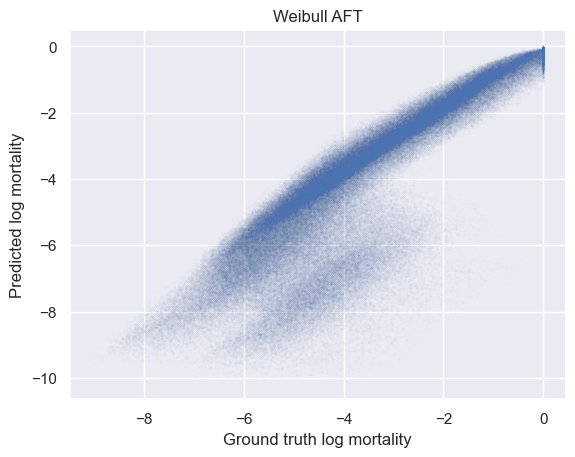

In [37]:
plt.plot(np.log(D2_test.mu), np.log(pred), '.', alpha=0.1, markersize=0.25)
plt.title("Weibull AFT")
plt.xlabel("Ground truth log mortality")
plt.ylabel("Predicted log mortality")
plt.show()

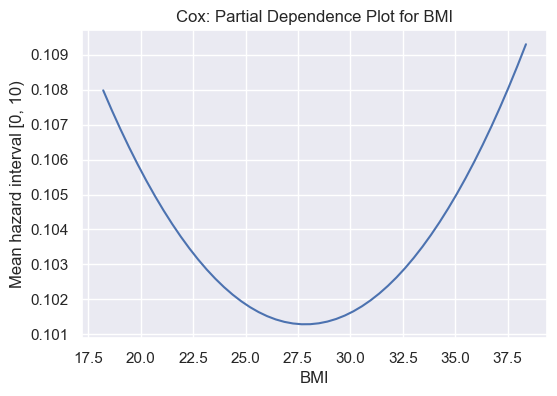

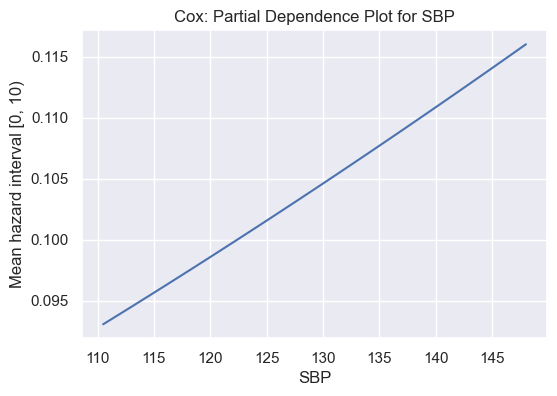

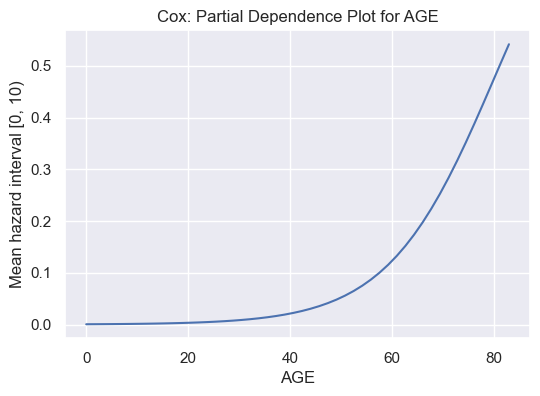

In [38]:
for var in ["BMI", "SBP", "AGE"]:
    plot_pdp(weibull_aft_D2, D2_test, var, 0, 10)

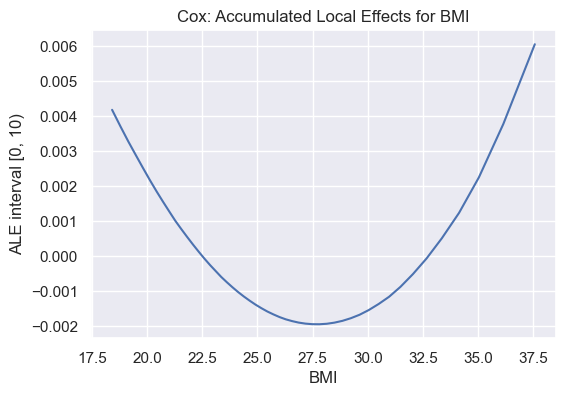

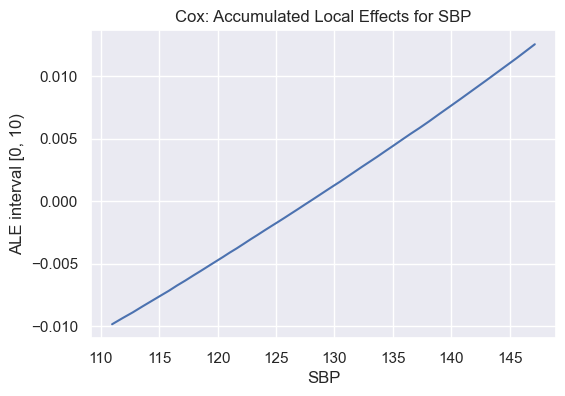

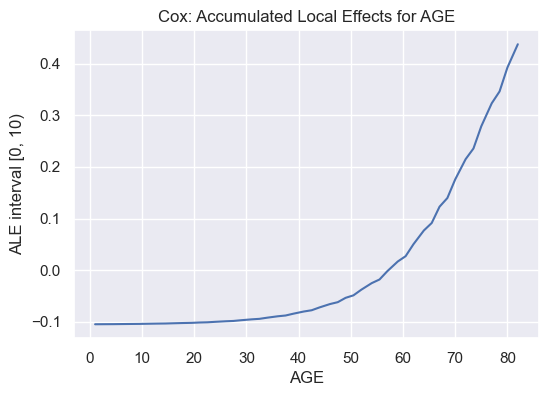

In [39]:
for var in ["BMI", "SBP", "AGE"]:
    plot_ale(weibull_aft_D2, D2_test, var, 0, 10)